In [17]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [18]:
df_atm = pd.read_csv('train.csv')

In [19]:
df_atm.head()

,DATE,ATM_ID,CLIENT_OUT
0,2015-01-01,0,91600
1,2015-01-02,0,136500
2,2015-01-03,0,335400
3,2015-01-04,0,379000
4,2015-01-05,0,344100


### Cast the type of data

In [20]:
df_atm = df_atm.assign(past_years=df_atm.loc[:, 'DATE']\
                       .apply(lambda x : int(x.split('-')[0]) - 2014))

In [21]:
df_atm = df_atm.assign(month=df_atm.loc[:, 'DATE'].apply(lambda x : x.split('-')[1]))

In [22]:
df_atm = df_atm.astype({'DATE': 'datetime64[ns]', 'month' : 'int8'})

In [23]:
def mapQuarter(x):
    return(x - 1) // 3 + 1

In [24]:
df_atm = df_atm.assign(Quarter=df_atm.loc[:, 'month'].apply(lambda x : mapQuarter(x)))

In [25]:
df_atm.head()

,DATE,ATM_ID,CLIENT_OUT,past_years,month,Quarter
0,2015-01-01,0,91600,1,1,1
1,2015-01-02,0,136500,1,1,1
2,2015-01-03,0,335400,1,1,1
3,2015-01-04,0,379000,1,1,1
4,2015-01-05,0,344100,1,1,1


In [26]:
df_atm = df_atm.astype({'DATE' : "datetime64[ns]", 'month' : 'int8'})

In [27]:
df_atm.dtypes

DATE          datetime64[ns]
ATM_ID                 int64
CLIENT_OUT             int64
past_years             int64
month                   int8
Quarter                int64
dtype: object

In [29]:
scaler = preprocessing.StandardScaler()
cols = ['past_years', 'ATM_ID', 'yearly_out']

In [33]:
X_scaled = pd.DataFrame(scaler.fit_transform(df_atm['CLIENT_OUT'].values.reshape(-1, 1)), columns=['CLIENT_OUT_scaled'])

X_scaled = pd.concat((df_atm['Quarter'], df_atm['past_years'],df_atm['ATM_ID'], X_scaled), axis=1)

In [34]:
yearly_out = X_scaled.pivot_table(index = 'ATM_ID', \
                                 columns = 'Quarter', aggfunc = {'CLIENT_OUT_scaled' : [np.min]})

In [38]:
from scipy.spatial.distance import cdist

In [39]:
def compute_cluster_centers(model,data):
    centers = []
    labs = model.labels_
    for i in range(max(labs)+1):
        centers.append(np.mean(data.values[np.where(labs==i)[0]], axis=0))
    return centers

def compute_distortion(model, data):
    return sum(np.min(cdist(data, compute_cluster_centers(model, data), 'euclidean'), axis=1)) / data.shape[0]

In [42]:
scores =[]
inertia = []
for k in range(2, 30):
    algo = KMeans(n_clusters=k).fit(yearly_out)
    labels = algo.labels_
    inertia.append(compute_distortion(algo, yearly_out))
    scores.append(silhouette_score(yearly_out, labels))

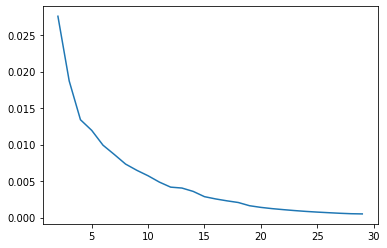

In [43]:
plt.plot(range(2, 30), inertia)

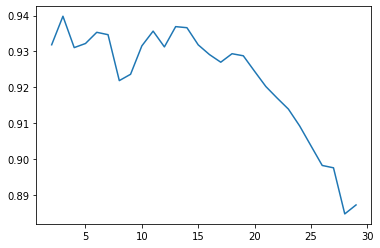

In [44]:
plt.plot(range(2, 30), scores)

In [45]:
np.argmax(scores) + 2

3

In [46]:
opt_algo = AgglomerativeClustering(14)
opt_algo.fit(yearly_out)
labels = opt_algo.labels_

In [47]:
groups = {}
for i in range(max(labels)+1):
    groups['atm_cluster_' + str(i)] = yearly_out.reset_index()['ATM_ID'].values[np.where(labels==i)[0]]

In [48]:
def associate_cluster(x, groups):
    for c in list(groups):
        #print(c)
        if x in groups[c]:
            break
    return c

In [49]:
df_atm.loc[:, 'atm_cluster'] = df_atm.loc[:,'ATM_ID'].apply(lambda x: associate_cluster(x,groups))

In [50]:
df_atm.groupby('atm_cluster').agg({'CLIENT_OUT' : "sum"})

,CLIENT_OUT
atm_cluster,
atm_cluster_0,2786015900
atm_cluster_1,1498623900
atm_cluster_10,2249177400
atm_cluster_11,664482500
atm_cluster_12,52268300
atm_cluster_13,325095400
atm_cluster_2,1331356200
atm_cluster_3,1207378600
atm_cluster_4,1118795100


In [52]:
# A.unique().shape